# Script to produce Fig. 2

## Load packages

In [17]:
import os
import xarray as xr
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from cartopy.mpl.geoaxes import GeoAxes
from mpl_toolkits.axes_grid1 import AxesGrid
import cartopy as crt
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import warnings
warnings.filterwarnings('ignore')

## Settings and folder paths

In [3]:
plt.style.use("seaborn-v0_8")
sns.set_style("darkgrid")
sns.set_context("notebook", font_scale=3.5)

idir = r'C:\Users\muis\OneDrive - Stichting Deltares\Desktop\paper_gtsmip\data'

models = ['EC-Earth3P-HR','HadGEM3-GC31-HM-SST','GFDL-CM4C192-SST','CMCC-CM2-VHR4','HadGEM3-GC31-HM']
rp = 10

## Load data and store in single DataFrame 

In [4]:
# bedlevel
ifile = 'data/bedlevel.nc'
ds_bedlevel = xr.open_dataset(ifile)
pxyn = ds_bedlevel.to_dataframe()

# ERA5
ifile = 'reanalysis_surge_actual-value_1985-2014_rp%s_best-fit_v1.nc' % str(rp)
ds_era5 = xr.open_dataset(os.path.join(idir,ifile))
df_era5 = ds_era5['return_mean_surge_level'].to_dataframe()
df_era5.rename(columns={df_era5 .columns[2]: 'era5'}, inplace = True)

# HighResMIP
df_models = []
for model in models:
    ifile = '%s_historical_surge_actual-value_1985-2014_rp%s_best-fit_v1.nc' % (str(model),str(rp))   
    ds_model = xr.open_dataset(os.path.join(idir,ifile))
    df_model = ds_model['return_mean_surge_level'].to_dataframe()
    df_model.rename(columns={df_model.columns[2]: model}, inplace = True)
    df_model.drop(columns=['station_x_coordinate','station_y_coordinate'],inplace=True)
    df_models.append(df_model)
df_data = pd.concat([df_era5, pd.concat(df_models, axis=1)], axis=1)

## Compute ensemble statistics and performance

In [5]:
# Compute ensemble stats
df_data['ens_std'] = df_data[models].std(axis=1)
df_data['ens_median'] = df_data[models].median(axis=1)

# Compute model performance
df_data['ens_median_abs_bias']=df_data['ens_median'].subtract(df_data['era5'],axis=0).rename('abs_bias')
df_data['ens_median_rel_bias']=df_data['ens_median'].subtract(df_data['era5'] ,axis=0).div(df_data['era5'],axis=0).mul(100).rename('rel_bias')

## Plot global maps

In [15]:
# function to plot global maps
def global_map(ax,pxyn,var,cm,clim,clabel):
    # Projections
    crg = crt.crs.PlateCarree() # the one we have defined the data
    crgp = crt.crs.Robinson() # the one to plot the data
    # Identify european coastal points
    lonmin = -35
    lonmax = 50
    latmin = 20
    latmax = 80
    depththresh = -20
    ioceaneu = pxyn[(pxyn['bedlevel']<depththresh)
                    &(pxyn['lat']<=latmax)&(pxyn['lat']>=latmin)
                    &(pxyn['lon']>=lonmin)&(pxyn['lon']<=lonmax)].index
    ioceanNeu = pxyn[(pxyn['bedlevel']<depththresh)
                    &((pxyn['lat']>latmax)|(pxyn['lat']<latmin)
                    |(pxyn['lon']<lonmin)|(pxyn['lon']>lonmax))].index
    # Identify coastal points    
    icoast = pxyn[pxyn['bedlevel']>=depththresh].index
    alfaoceaneu = 0.1
    alfaoceanNeu = 0.4
    alfacoast = 1
    psoceaneu = 4
    psoceanNeu = 20
    pscoast = 6
    # format
    mpl.rcParams.update({'font.size': 20})
    # plot map 
    ax.set_global()
    ax.set_extent([-180, 180, -60, 70], crg)            
    ax.coastlines(resolution='10m', color='gray', linewidth=0.5, alpha=0.8,zorder=6)
    ax.add_feature(crt.feature.LAND.with_scale('10m'),facecolor='gray',zorder=4,alpha=0.20)
    ax.add_feature(crt.feature.LAKES.with_scale('10m'), facecolor='gray',zorder=5,alpha=0.05)        
    ax.add_feature(crt.feature.OCEAN.with_scale('10m'), edgecolor='face', facecolor='white')
    # plot data
    bs=ax.scatter(x=pxyn.loc[ioceaneu,'lon'].values,y=pxyn.loc[ioceaneu,'lat'].values,alpha=alfaoceaneu,s=psoceaneu,c=var.loc[ioceaneu].values,cmap=cm,vmin=clim[0], vmax=clim[1],transform=crg)
    bs=ax.scatter(x=pxyn.loc[ioceanNeu,'lon'].values,y=pxyn.loc[ioceanNeu,'lat'].values,alpha=alfaoceanNeu,s=psoceanNeu,c=var.loc[ioceanNeu].values,cmap=cm,vmin=clim[0], vmax=clim[1],transform=crg)
    bs=ax.scatter(x=pxyn.loc[icoast,'lon'].values,y=pxyn.loc[icoast,'lat'].values,alpha=alfacoast,s=pscoast,c=var.loc[icoast].values,cmap=cm,vmin=clim[0], vmax=clim[1],transform=crg)  
    # Format lat lon grid    
    gl = ax.gridlines(crs=crg, draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.yline = gl.xlines = True
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.ylabel_style = {'size': 12, 'color': 'gray'}
    gl.xlabel_style = {'rotation': 0, 'size': 12, 'color': 'gray'}
    gl.top_labels = gl.right_labels = False
    gl.ylocator = mpl.ticker.FixedLocator(np.arange(-60.,61.,20))
    gl.xlocator = mpl.ticker.FixedLocator(np.arange(-180.,181.,40))
    # Colorbar
    cbar = ax.cax.colorbar(bs)
    cbar.set_label(label=clabel,size=12)
    # Tight layout and save
    plt.tight_layout()
    return ax

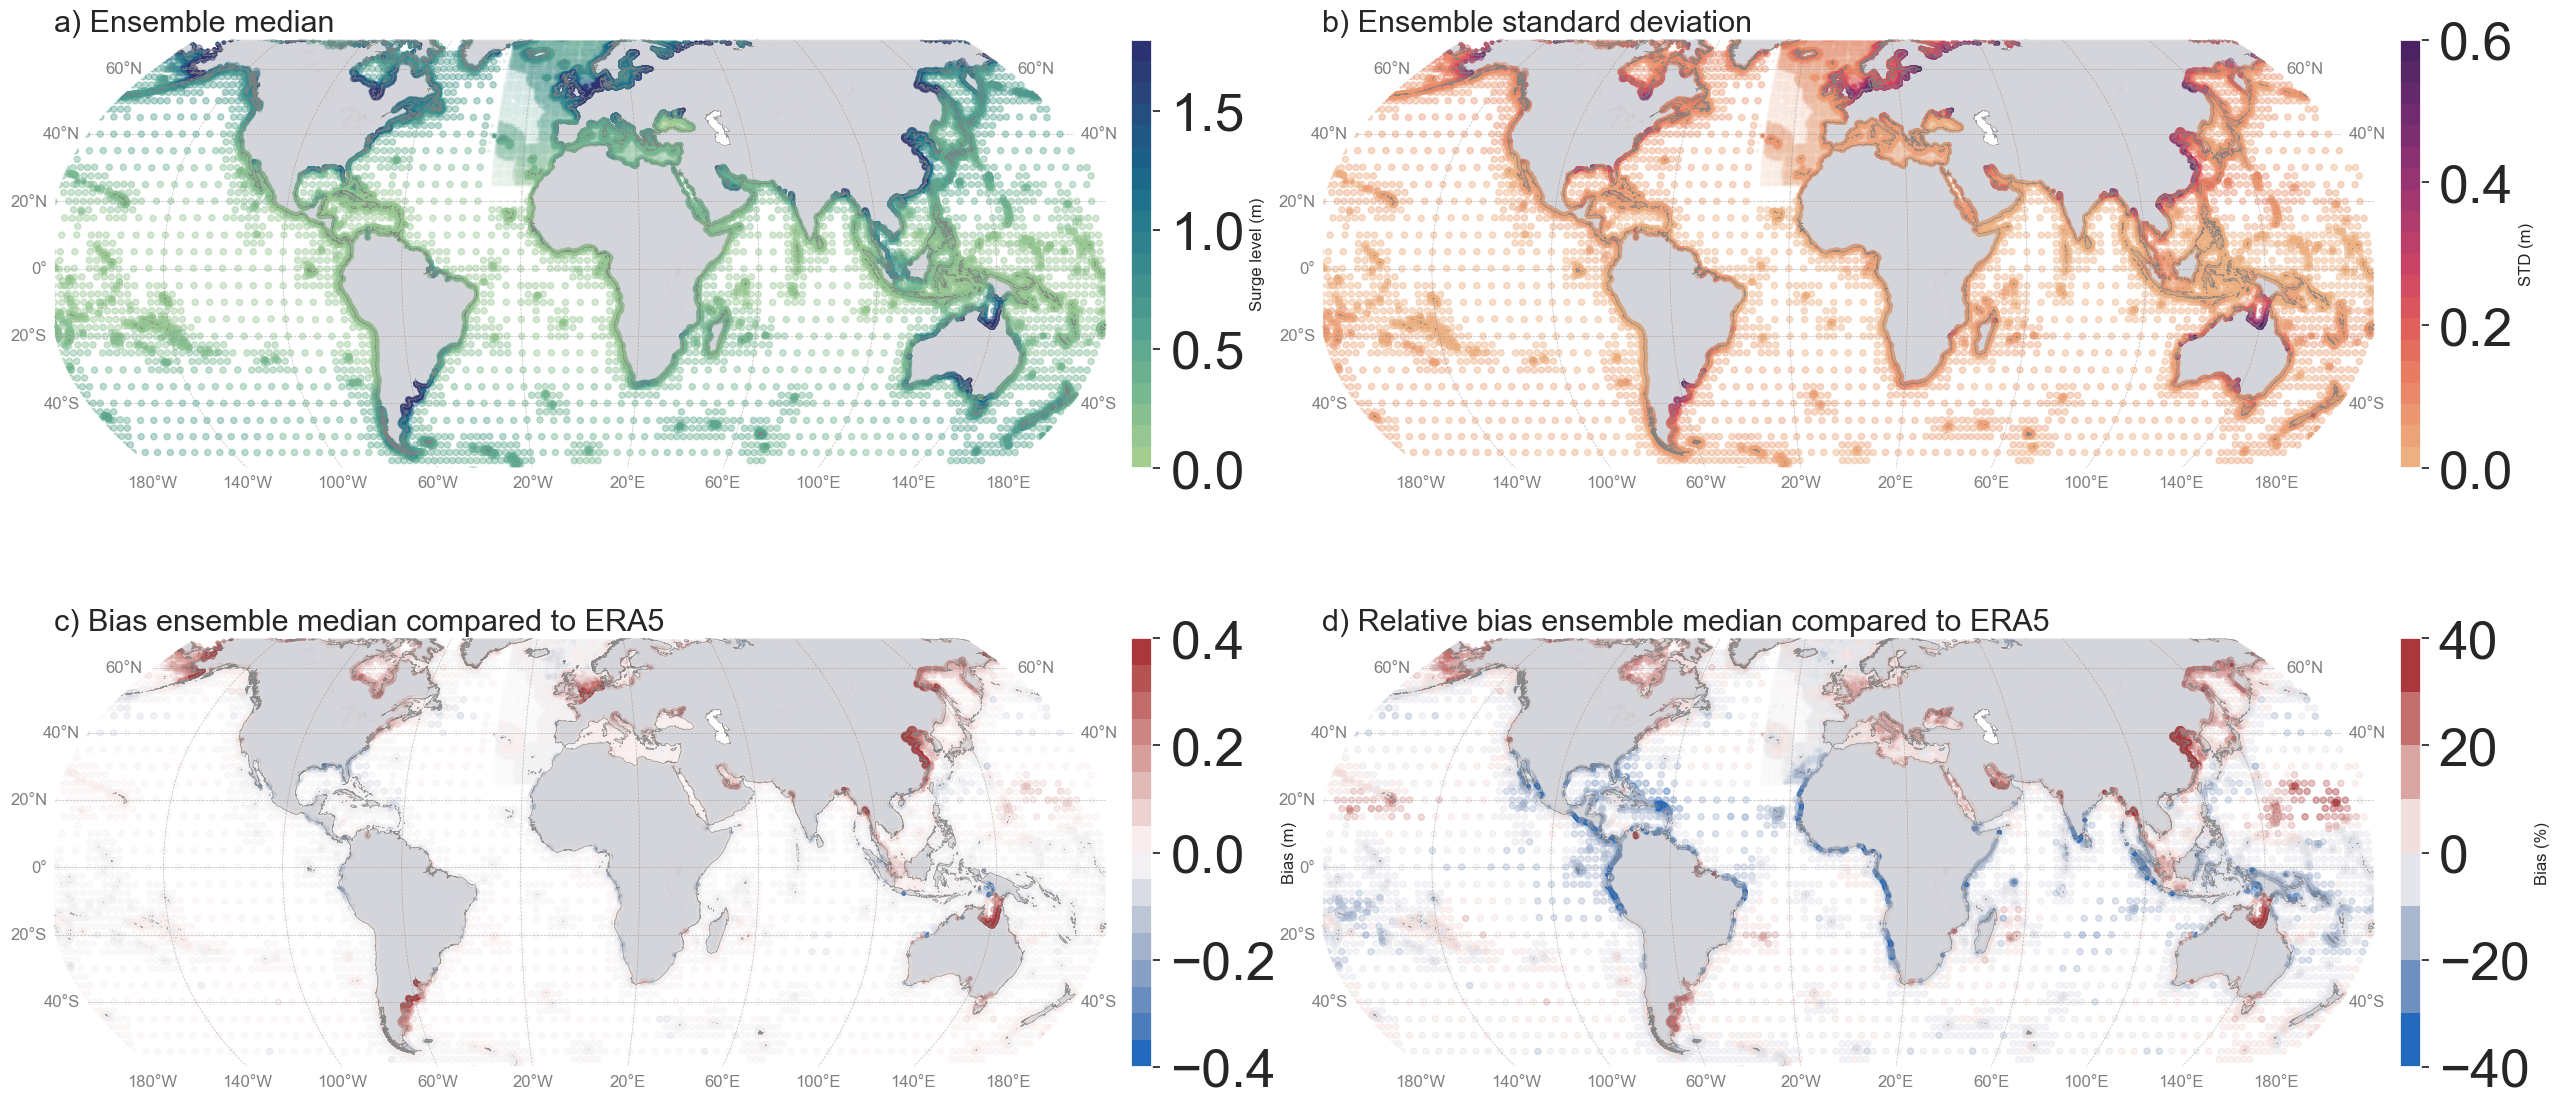

In [19]:
fig = plt.figure(figsize=(26,20))
axes_class = (GeoAxes, dict(projection=crt.crs.Robinson()))
axs = AxesGrid(fig, 111, axes_class=axes_class,
               nrows_ncols=(2, 2),
               share_all=True,
               axes_pad=1.7,
               cbar_location='right',
               cbar_mode='each',
               cbar_size='2%',
               cbar_pad=0.25,
               label_mode='keep') 
# panel a - ensemble median
axs[0].set_title("a) Ensemble median", size=22, loc='left')
cm = mpl.colormaps['crest'].resampled(20)
clim=[0,1.8]
label='Surge level (m)'
global_map(axs[0], pxyn,df_data['ens_median'], cm, clim, label)
# panel b - ensemble std
axs[1].set_title('b) Ensemble standard deviation', size=22, loc='left')
cm = mpl.colormaps['flare'].resampled(20)
clim=[0,.6]
label='STD (m)'
global_map(axs[1], pxyn, df_data['ens_std'],cm, clim, label)
# panel c - bias
axs[2].set_title('c) Bias ensemble median compared to ERA5', size=22,loc='left')
cm = mpl.colormaps['vlag'].resampled(16)
clim=[-.4,.4]
label='Bias (m)'
global_map(axs[2], pxyn, df_data['ens_median_abs_bias'],cm, clim, label)
# panel d - relative bias
axs[3].set_title('d) Relative bias ensemble median compared to ERA5 ', size=22,loc='left')
cm = mpl.colormaps['vlag'].resampled(8)
clim=[-40,40]
label='Bias (%)'
global_map(axs[3], pxyn, df_data['ens_median_rel_bias'],cm, clim, label)
plt.show()